In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score

In [46]:
train = pd.read_csv('../data/train.csv')
cols = [i for i in train.columns]
train.Date = pd.to_datetime(train.Date)

# deal with NaNs
for i in train.columns[train.isnull().sum()>0]: # for all the columns with nans
    mean_avg_temp = train.loc[train[i].isnull()==True,'Tavg'].mean() # what is the mean Tavg
    mean_i_val = train.loc[train.Tavg==mean_avg_temp,i].mean() # what is i val for that Tavg
    train.loc[train[i].isnull()==True,'to_fill'] = mean_i_val
    train[i] = train[i].fillna(train.to_fill)
    train.drop('to_fill',axis=1,inplace=True)

# remove date columns
dates = ['_date-'+str(i) for i in range(1,7)]
for i,v in enumerate(cols):
    try:
        if v in dates: # drops out the repeated date column
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    try:
        if 'Date_date-' in v:
            train.drop(v,axis=1,inplace=True)
    except:
        pass
    
# label encode Species and Trap
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
le = LabelEncoder()
le.fit(train.Species)
train['mosquito'] = le.transform(train.Species)
le.fit(train.Trap)
train['trap_e'] = le.transform(train.Trap)
cols = [i for i in train.columns]
X_cols = cols[13:]
X_cols.append('Latitude')
X_cols.append('Longitude')
X_cols.append('AddressAccuracy')
# X_cols.append('NumMosquitos')

# set up y
y = train.dropna()['WnvPresent']

# set up and standardize X
X_values = train[X_cols].dropna().values # convert to numpy array
ss = StandardScaler()
X_std = ss.fit_transform(X_values)

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(m):
    model = m.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred,labels =[0,1])
    class_report = classification_report
    print m,'\n'
    print "Accuracy Score:\t{:0.3}".format(score.round(3)),'\n\n'
    crossval = cross_val_score(m, X, y,cv=7)
    print "Cross Val Scores:", crossval,'\n'
    print "Cross Val mean ± Std. Dev:{:0.3}".format(np.mean(crossval), ' ± ',np.std(crossval)),'\n'
    print "Predicted Totals:"
    for i,v in enumerate(np.bincount(y)):
        print "class "+str(i)+':' , v
    print "\nConfusion Matrix:"
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['Actual 1', 'Actual 0'],
                         columns=['Predicted 1','Predicted 0'])
    print(confusion),'\n'
    print "Classification Report:"
    print(classification_report(y_test, y_pred, target_names=['0','1']))
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specificity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Non-PCA section

In [78]:
# X for train test split (non-PCA)
X = X_std
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 

Accuracy Score:	0.94 


Cross Val Scores: [ 0.93136582  0.48387097  0.85498282  0.91546392  0.83436426  0.81168385
  0.62817869] 

Cross Val mean ± Std. Dev:0.78 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           25          149
Actual 0           53         3136 

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      3189
          1       0.32      0.14      0.20       174

avg / total       0.92      0.94      0.93      3363



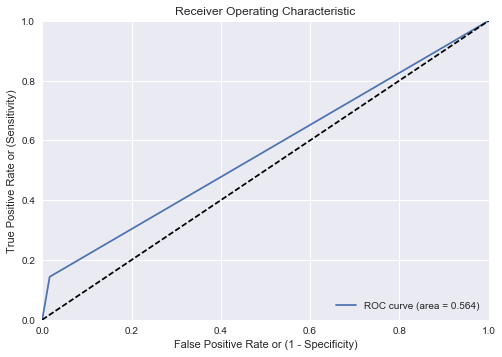

In [79]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
evaluate_model(clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None) 

Accuracy Score:	0.94 


Cross Val Scores: [ 0.94783802  0.60878518  0.91134021  0.94845361  0.88591065  0.89278351
  0.71408935] 

Cross Val mean ± Std. Dev:0.844 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           36          138
Actual 0           64         3125 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.36

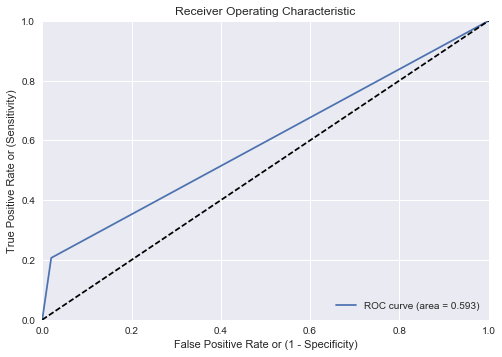

In [80]:
from sklearn.ensemble import AdaBoostClassifier
rf = RandomForestClassifier(max_features = 10)
clf = AdaBoostClassifier(base_estimator=rf)
evaluate_model(clf)

In [81]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [82]:
features = pd.DataFrame({'Feature':train[X_cols].columns,
                         'Importance':np.round(rf.feature_importances_,6)})
features.sort_values(by='Importance',ascending=False)

,Feature,Importance
584,mosquito,0.196802
547,SeaLevel_date-6,0.011715
458,StnPressure_date-4,0.010052
323,DewPoint_date-1,0.009807
415,SeaLevel_date-3,0.009303
412,WetBulb_date-3,0.008983
329,ResultDir_date-1,0.008431
322,Tavg_date-1,0.008258
374,AvgSpeed_date-2,0.007928
414,StnPressure_date-3,0.007764


## PCA

In [76]:
# PCA, remember to run in this section before you run the below.
from sklearn.decomposition import PCA
pca = PCA(n_components=31,svd_solver='full') # 30 components describe 85% of variance
pca.fit(X)
X_pca = pca.transform(X)
# print pca.explained_variance_ratio_
print pca.explained_variance_ratio_.sum()
X_train, X_test, y_train, y_test = train_test_split(X_pca, y,stratify=y, test_size=0.33)

0.85528346836


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False) 

Accuracy Score:	0.942 


Cross Val Scores: [ 0.94783802  0.23335621  0.70790378  0.94845361  0.52508591  0.46872852
  0.29003436] 

Cross Val mean ± Std. Dev:0.589 

Predicted Totals:
class 0: 9662
class 1: 527

Confusion Matrix:
          Predicted 1  Predicted 0
Actual 1           26          148
Actual 0           48         3141 

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      3189
          1       0.35      0.15      0.21       174

avg / total       0.92      0.94      0.93      3363



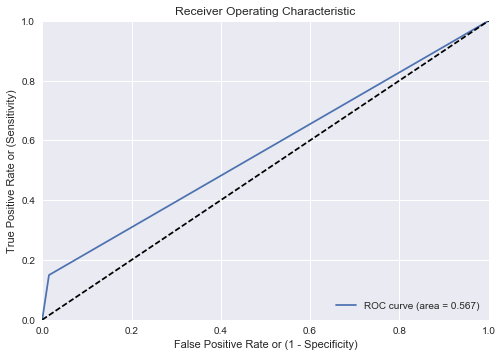

In [77]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features=.8)
evaluate_model(clf)